### Testing the distribution of orders to determine the validitiy of Hawkes processes or exponential distribution (independant)

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import seaborn as sns
import matplotlib.gridspec as gridspec


from BSE import market_session

In [3]:
# Set global font sizes
plt.rcParams['font.size'] = 18  # Default font size for all text
plt.rcParams['axes.titlesize'] = 18  # Font size for plot titles
plt.rcParams['axes.labelsize'] = 18  # Font size for x and y axis labels
plt.rcParams['xtick.labelsize'] = 18  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 18  # Font size for y tick labels
plt.rcParams['legend.fontsize'] = 18  # Font size for legend
plt.rcParams['figure.titlesize'] = 18  # Font size for figure titles

In [4]:
id = 'new_trader_chart_0_'
#id = 'heston_model_session_0_'
file_path = id + 'LOB_frames.csv'
prices = id + "tape.csv"
volumes = id + 'blotters.csv'
balances = id + 'avg_balance.csv'

In [5]:
tape_df = pd.read_csv(prices, header=None, names=['Type', 'Time', 'Price'])

# Display the DataFrame
tape_df.head(5)


,Type,Time,Price
0,Trd,0.400,141
1,Trd,0.458,179
2,Trd,0.683,230
3,Trd,0.700,231
4,Trd,0.767,222


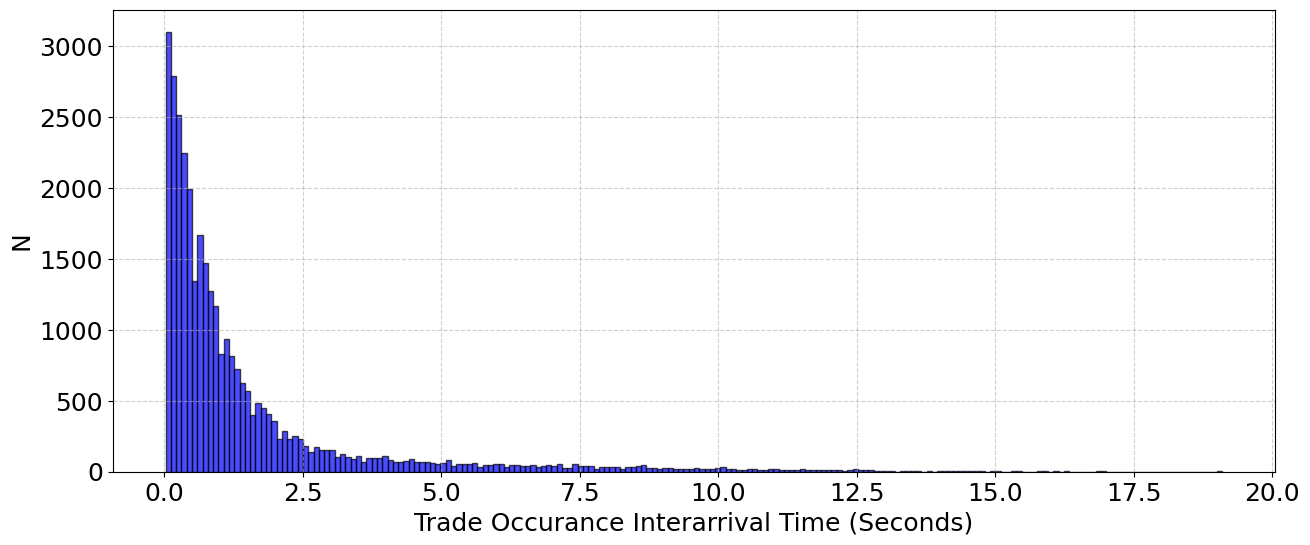

In [6]:
transactions = pd.read_csv('combined_tape.csv')
trade_times = transactions["timestamp"].values

inter_arrival_times = np.diff(trade_times)
inter_arrival_times = inter_arrival_times [inter_arrival_times > 0]  # Restrict data
inter_arrival_times = inter_arrival_times [inter_arrival_times < 100]  # Restrict data

# Plot histogram of inter-arrival times
plt.figure(figsize=(15, 6))
plt.hist(inter_arrival_times, bins=200, color='blue', alpha=0.7, edgecolor='black', density=False)
plt.xlabel("Trade Occurance Interarrival Time (Seconds)")
plt.ylabel("N")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

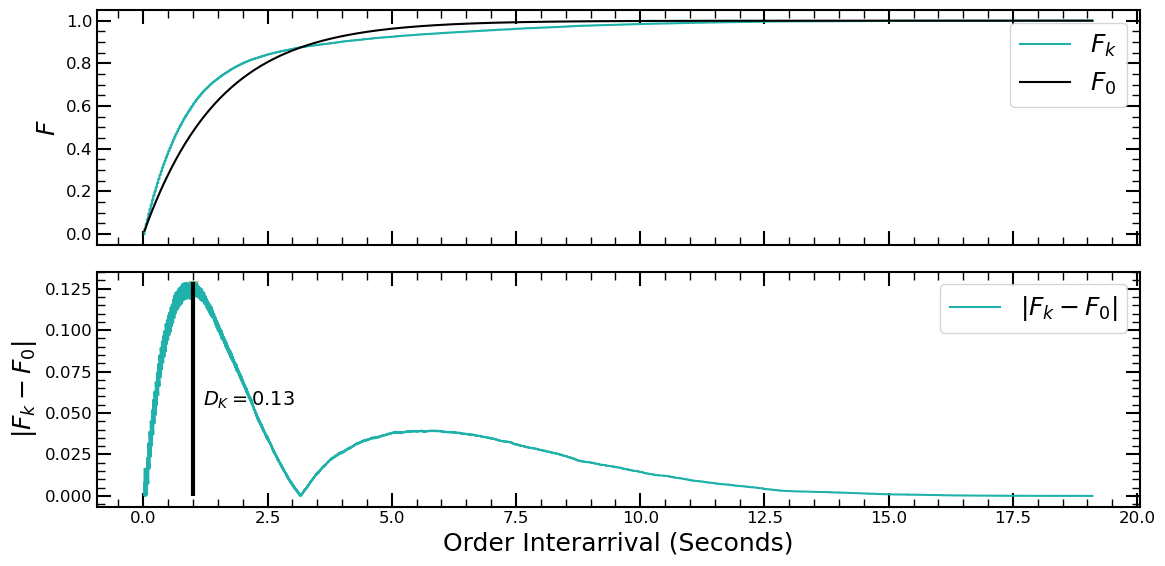

KS Statistic: 0.1288
P-Value: 1e-16
Reject the null hypothesis: Trades deviate from a Poisson process.


In [7]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

filtered_data = inter_arrival_times #[inter_arrival_times < 5]  # Restrict data

# === Compute Theoretical CDF (Exponential Fit) ===
x = np.linspace(min(inter_arrival_times), max(inter_arrival_times), 100)
sorted_data = np.sort(filtered_data)
N = len(sorted_data)
lambda_hat = 1 / np.mean(filtered_data)
exp_dist = stats.expon(scale=1 / lambda_hat)
theoretical_cdf = exp_dist.cdf(sorted_data)

# === Compute KS Test ===
D_statistic, p_value = stats.kstest(filtered_data, exp_dist.cdf)
p_value = max(p_value, 1e-16)
# === Compute Kolmogorov-Smirnov Confidence Bands ===
def ks_confidence_band(N, alpha=0.05):
    """Compute KS confidence bands centered around F0."""
    c_alpha = stats.kstwobign.ppf(1 - alpha)  # Critical value
    margin = c_alpha / np.sqrt(N)  # Compute confidence interval width
    return margin

# Compute confidence intervals around the theoretical CDF
margin_95 = ks_confidence_band(N, alpha=0.05)
margin_99 = ks_confidence_band(N, alpha=0.01)
lower_95, upper_95 = np.clip(theoretical_cdf - margin_95, 0, 1), np.clip(theoretical_cdf + margin_95, 0, 1)
lower_99, upper_99 = np.clip(theoretical_cdf - margin_99, 0, 1), np.clip(theoretical_cdf + margin_99, 0, 1)

# === Generate KS Test Plot ===
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

# === Upper Plot: Empirical vs Theoretical CDF ===
axes[0].plot(sorted_data, np.arange(1, N + 1) / N, label=r"$F_k$", color="lightseagreen")
axes[0].plot(sorted_data, theoretical_cdf, label=r"$F_0$", color="black")

#axes[0].fill_between(sorted_data, lower_99, upper_99, color='gray', alpha=0.3, label="99% CI")
#axes[0].fill_between(sorted_data, lower_95, upper_95, color='gray', alpha=0.5, label="95% CI")

axes[0].set_ylabel(r"$F$")
axes[0].legend()

# === Lower Plot: KS Statistic Difference ===
empirical_cdf = np.arange(1, N + 1) / N
ks_diff = np.abs(empirical_cdf - theoretical_cdf)

axes[1].plot(sorted_data, ks_diff, label=r"$|F_k - F_0|$", color="lightseagreen")
# Find the max KS difference point
max_diff_index = np.argmax(ks_diff)
max_x = sorted_data[max_diff_index]  # X value at max difference
max_y = ks_diff[max_diff_index]  # Y value at max difference

# Plot a vertical line at the max point with a cap
axes[1].vlines(max_x, 0, max_y, color='black', linestyle='solid', linewidth=3)
axes[1].scatter(max_x, max_y, color='darkseagreen', s=50, marker='_', linewidth=2)  # Cap marker

# Annotate the maximum point
offset = max_y * 0.05
offset_x = max_x + 0.001
axes[1].text(offset_x *1.2, max_y - offset * 12, f"$D_K={D_statistic:.2f}$", fontsize=14, color='black', ha='left', va='bottom')


axes[1].set_ylabel(r"$|F_k - F_0|$")
axes[1].legend()
axes[1].minorticks_on()
axes[0].minorticks_on()
axes[0].tick_params(axis='both', which='major', direction='in', length=10, width=1.5, labelsize=12,
                    top=True, bottom=True, left=True, right=True)
axes[0].tick_params(axis='both', which='minor', direction='in', length=6, width=1,
                    top=True, bottom=True, left=True, right=True)
axes[1].tick_params(axis='both', which='major', direction='in', length=10, width=1.5, labelsize=12,
                    top=True, bottom=True, left=True, right=True)
axes[1].tick_params(axis='both', which='minor', direction='in', length=6, width=1,
                    top=True, bottom=True, left=True, right=True)


# Apply thicker border edges to both subplots
for ax in axes:
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)  # Adjust thickness (2 is thicker, increase if needed)
        


plt.xlabel("Order Interarrival (Seconds)")
#plt.xlim(0, 1)  # Restrict x-axis to 0.1
plt.tight_layout()
plt.show()

# Print KS Test Results
print(f"KS Statistic: {D_statistic:.4f}")
print(f"P-Value: {p_value:.4g}")
if p_value < 0.05:
    print("Reject the null hypothesis: Trades deviate from a Poisson process.")
else:
    print("Fail to reject the null hypothesis: Trades are consistent with a Poisson process.")





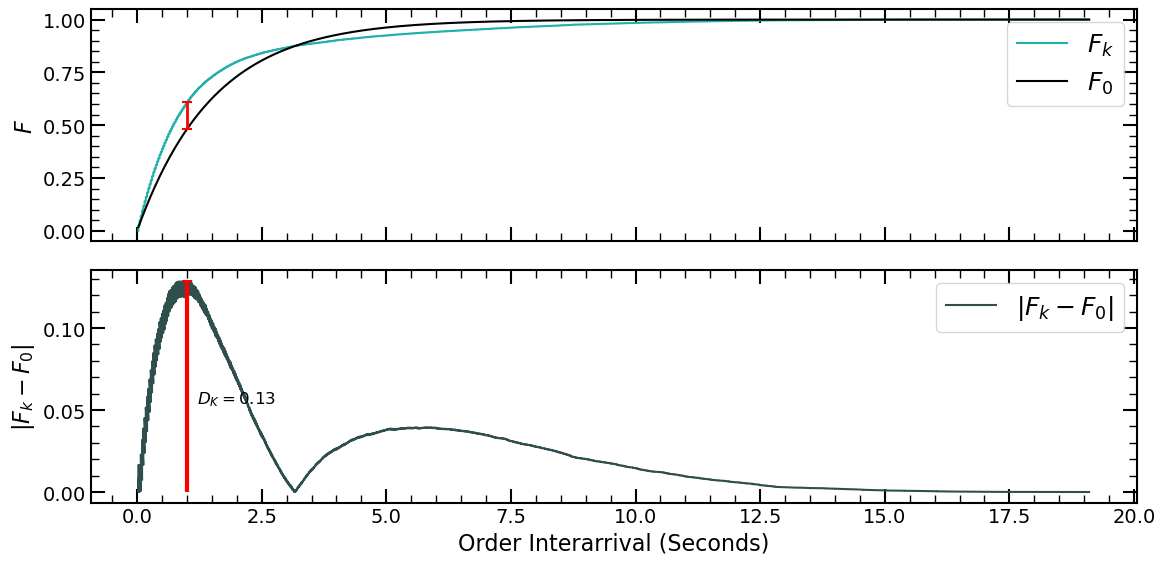

KS Statistic: 0.1288
P-Value: 1e-16
Reject the null hypothesis: Trades deviate from a Poisson process.


In [33]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

filtered_data = inter_arrival_times  # [inter_arrival_times < 5]  # Restrict data if desired

# === Compute Theoretical CDF (Exponential Fit) ===
x = np.linspace(min(inter_arrival_times), max(inter_arrival_times), 100)
sorted_data = np.sort(filtered_data)
N = len(sorted_data)
lambda_hat = 1 / np.mean(filtered_data)
exp_dist = stats.expon(scale=1 / lambda_hat)
theoretical_cdf = exp_dist.cdf(sorted_data)

# === Compute KS Test ===
D_statistic, p_value = stats.kstest(filtered_data, exp_dist.cdf)
p_value = max(p_value, 1e-16)

# === Compute Kolmogorov-Smirnov Confidence Bands ===
def ks_confidence_band(N, alpha=0.05):
    """Compute KS confidence bands centered around F0."""
    c_alpha = stats.kstwobign.ppf(1 - alpha)
    margin = c_alpha / np.sqrt(N)
    return margin

margin_95 = ks_confidence_band(N, alpha=0.05)
margin_99 = ks_confidence_band(N, alpha=0.01)
lower_95, upper_95 = np.clip(theoretical_cdf - margin_95, 0, 1), np.clip(theoretical_cdf + margin_95, 0, 1)
lower_99, upper_99 = np.clip(theoretical_cdf - margin_99, 0, 1), np.clip(theoretical_cdf + margin_99, 0, 1)

# === Generate KS Test Plot (2 Subplots) ===
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True,
                         gridspec_kw={'height_ratios': [1, 1]})

# -------------------------------------------------
# UPPER PLOT: Empirical vs Theoretical CDF
# -------------------------------------------------
axes[0].plot(sorted_data, np.arange(1, N + 1) / N, label=r"$F_k$", color="lightseagreen")
axes[0].plot(sorted_data, theoretical_cdf, label=r"$F_0$", color="black")

# Uncomment to show confidence intervals if desired:
# axes[0].fill_between(sorted_data, lower_99, upper_99, color='gray', alpha=0.3, label="99% CI")
# axes[0].fill_between(sorted_data, lower_95, upper_95, color='gray', alpha=0.5, label="95% CI")

axes[0].set_ylabel(r"$F$", fontsize = 16)
axes[0].legend()

# -------------------------------------------------
# LOWER PLOT: KS Statistic Difference
# -------------------------------------------------
empirical_cdf = np.arange(1, N + 1) / N
ks_diff = np.abs(empirical_cdf - theoretical_cdf)

axes[1].plot(sorted_data, ks_diff, label=r"$|F_k - F_0|$", color="darkslategray")

# --- Find the max KS difference point ---
max_diff_index = np.argmax(ks_diff)
max_x = sorted_data[max_diff_index]   # X value at max difference
max_y = ks_diff[max_diff_index]       # Y value at max difference

# --- Plot vertical line + marker in lower plot ---
axes[1].vlines(max_x, 0, max_y, color='red', linestyle='solid', linewidth=3)
axes[1].scatter([max_x], max_y, marker='_', s=50, color='red', zorder=3)

axes[1].scatter(max_x, max_y, color='darkseagreen', s=50, marker='_', linewidth=2)  # Cap marker

# --- Annotate the maximum point in lower plot ---
offset = max_y * 0.05
offset_x = max_x + 0.001
axes[1].text(offset_x*1.2, max_y - offset*12, f"$D_K={D_statistic:.2f}$", 
             fontsize=12, color='black', ha='left', va='bottom')

axes[1].set_ylabel(r"$|F_k - F_0|$", fontsize = 16)
axes[1].legend()
axes[1].minorticks_on()

# -------------------------------------------------
# DRAW RED VERTICAL LINE ON UPPER PLOT
# -------------------------------------------------
# We'll connect the empirical CDF and theoretical CDF at the max difference x-value.
y_emp = empirical_cdf[max_diff_index]
y_theo = theoretical_cdf[max_diff_index]
# Plot a vertical line from the lower of the two y-values to the higher
y_min, y_max = min(y_emp, y_theo), max(y_emp, y_theo)

axes[0].vlines(x=max_x, ymin=y_min, ymax=y_max, 
               color='red', linestyle='-', linewidth=2)

# Optionally add small markers where it crosses each CDF
axes[0].scatter([max_x], [y_emp], marker='_', s=50, color='red', zorder=3)
axes[0].scatter([max_x], [y_theo], marker='_', s=50, color='red', zorder=3)

# -------------------------------------------------
# Final Ticks & Layout
# -------------------------------------------------
axes[0].minorticks_on()
axes[0].tick_params(axis='both', which='major', direction='in',
                    length=10, width=1.5, labelsize=14, top=True, bottom=True, left=True, right=True)
axes[0].tick_params(axis='both', which='minor', direction='in', length=6, width=1,
                    top=True, bottom=True, left=True, right=True)
axes[1].tick_params(axis='both', which='major', direction='in',
                    length=10, width=1.5, labelsize=14, top=True, bottom=True, left=True, right=True)
axes[1].tick_params(axis='both', which='minor', direction='in', length=6, width=1,
                    top=True, bottom=True, left=True, right=True)

for ax in axes:
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

plt.xlabel("Order Interarrival (Seconds)", fontsize = 16)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Print KS Test Results
# -------------------------------------------------
print(f"KS Statistic: {D_statistic:.4f}")
print(f"P-Value: {p_value:.4g}")
if p_value < 0.05:
    print("Reject the null hypothesis: Trades deviate from a Poisson process.")
else:
    print("Fail to reject the null hypothesis: Trades are consistent with a Poisson process.")


----


KS Statistic: 0.003065775567512752
P-Value: 0.9185659774743391


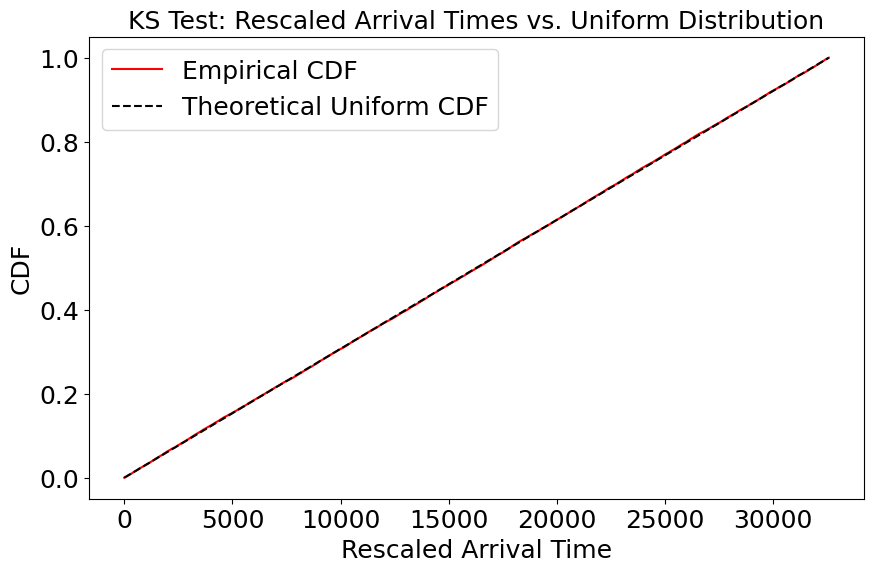

In [9]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Suppose inter_arrival_times is your observed data for inter-arrival times.
# For example, you might have:
# inter_arrival_times = np.array([...])
# (Here, we assume inter_arrival_times is already defined.)

# Compute the cumulative arrival times
arrival_times = np.cumsum(inter_arrival_times)

# Total observation time T. (Assuming the first arrival time is 0, else subtract the first arrival.)
T = arrival_times[-1]  # or: T = arrival_times[-1] - arrival_times[0]
# Total number of events
N = len(arrival_times)

# Estimate the average intensity (events per unit time)
a_lambda = N / T

# Rescale the arrival times by the estimated intensity
x = np.random.uniform(0.5, 1.1, N)  # Generate N uniform random variables
residual_arrival_times = a_lambda * arrival_times 

# Under a homogeneous Poisson process, the rescaled arrival times should be uniformly distributed on [0, N].
# Define the theoretical CDF for a Uniform[0, N] distribution:
theoretical_cdf = lambda x: x / N  # valid for 0 <= x <= N

# Perform the KS test comparing the residual arrival times to the uniform CDF.
res = stats.kstest(residual_arrival_times, theoretical_cdf)
print("KS Statistic:", res.statistic)
print("P-Value:", res.pvalue)

# --- Plotting the results ---
# Sort the residual arrival times
sorted_resid = np.sort(residual_arrival_times)
# Empirical CDF: fraction of events below each sorted residual time.
empirical_cdf = np.arange(1, N + 1) / N
# The theoretical CDF for the uniform distribution on [0, N] is simply x/N.
theo_cdf_vals = sorted_resid / N

plt.figure(figsize=(10, 6))
plt.plot(sorted_resid, empirical_cdf, label="Empirical CDF", color="red")
plt.plot(sorted_resid, theo_cdf_vals, label="Theoretical Uniform CDF", color="black", linestyle="--")
plt.xlabel("Rescaled Arrival Time")
plt.ylabel("CDF")
plt.title("KS Test: Rescaled Arrival Times vs. Uniform Distribution")
plt.legend()
plt.show()


---

LB Test

In [10]:
import statsmodels.stats.diagnostic as diag
import pandas as pd

lags_list = [1,2,3,4,5,6,7,8,9,10]

# Return a DataFrame with columns "lb_stat" and "lb_pvalue"
df = diag.acorr_ljungbox(inter_arrival_times, lags=lags_list, return_df=True)
print(df)

for lag in lags_list:
    # The index of df will be the lags, so we can locate the row by 'lag'
    lb_val = df.loc[lag, 'lb_stat']
    p_val  = df.loc[lag, 'lb_pvalue']
    print(f"Lag {lag}: LB stat={lb_val:.4f}, p={p_val:.4g}")


       lb_stat     lb_pvalue
1     4.912098  2.666923e-02
2    19.791757  5.038190e-05
3    41.037322  6.421095e-09
4    51.502690  1.752583e-10
5    52.549430  4.161565e-10
6    53.109763  1.115065e-09
7    53.677727  2.723604e-09
8    64.251436  6.784723e-11
9   103.667998  2.844634e-18
10  149.201799  5.440033e-27
Lag 1: LB stat=4.9121, p=0.02667
Lag 2: LB stat=19.7918, p=5.038e-05
Lag 3: LB stat=41.0373, p=6.421e-09
Lag 4: LB stat=51.5027, p=1.753e-10
Lag 5: LB stat=52.5494, p=4.162e-10
Lag 6: LB stat=53.1098, p=1.115e-09
Lag 7: LB stat=53.6777, p=2.724e-09
Lag 8: LB stat=64.2514, p=6.785e-11
Lag 9: LB stat=103.6680, p=2.845e-18
Lag 10: LB stat=149.2018, p=5.44e-27


In [11]:
from statsmodels.stats.diagnostic import acorr_ljungbox
# === Perform Ljung-Box Test ===
lb_test = acorr_ljungbox(inter_arrival_times, lags=[10], return_df=True)  # Test up to lag 10

# Extract test results
lb_stat = lb_test["lb_stat"].values[0]
p_value = lb_test["lb_pvalue"].values[0]

# === Print Results ===
print(f"Ljung-Box Test Statistic: {lb_stat:.4f}")
print(f"P-Value: {p_value:.4g}")

# Interpret the Result
if p_value < 0.05:
    print("Reject the null hypothesis: Inter-arrival times exhibit autocorrelation (not independent). Not Poisson like")
else:
    print("Fail to reject the null hypothesis: Inter-arrival times are independently distributed.")

Ljung-Box Test Statistic: 149.2018
P-Value: 5.44e-27
Reject the null hypothesis: Inter-arrival times exhibit autocorrelation (not independent). Not Poisson like


In [12]:
0.025
0.0108
0.0355

0.0355

---

LB Test over many trials 

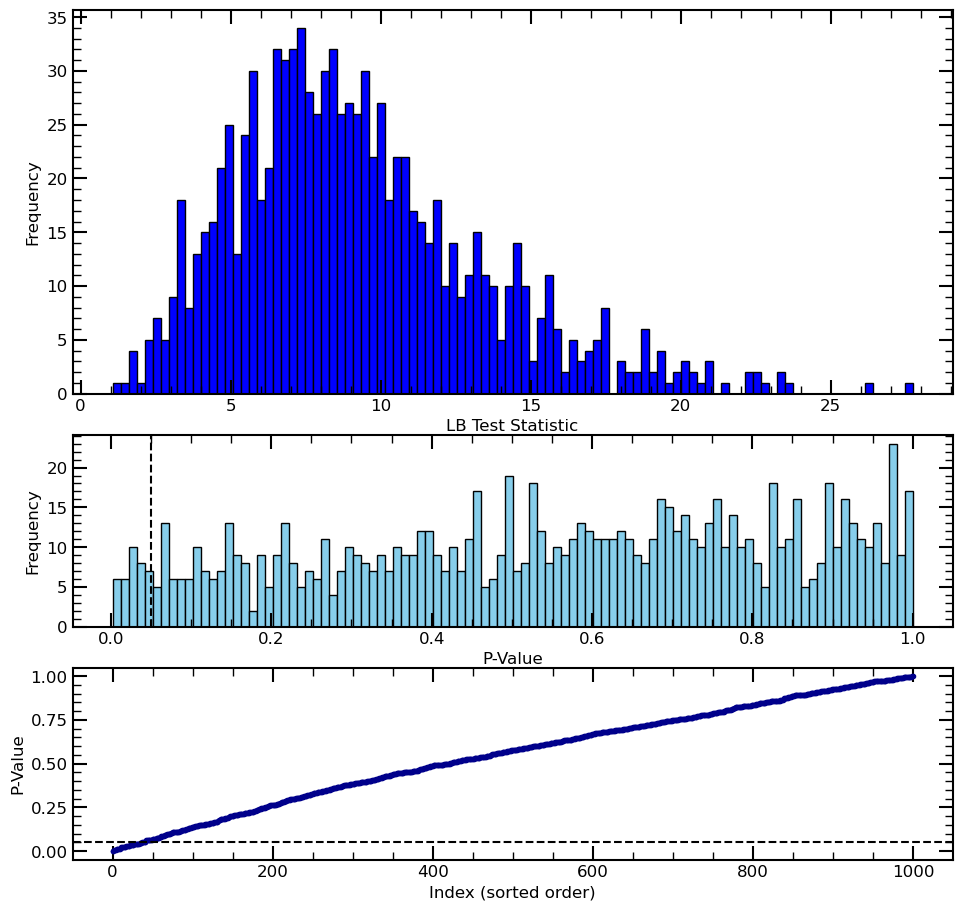

In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Read your data
prices = 'combined_tape.csv'
tape_df = pd.read_csv(prices)

# Assign a group number whenever 'timestamp' resets (goes backward)
tape_df['Group'] = (tape_df['timestamp'] < tape_df['timestamp'].shift()).cumsum()

# Prepare lists to hold LB test statistics and p-values
lb_stats = []
p_vals = []

# Loop over each group
for grp, grp_df in tape_df.groupby('Group'):
    # Calculate interarrival times within the group
    intervals = grp_df['timestamp'].diff().dropna()
    
    # Skip groups that are too small
    if len(intervals) < 2:
        continue
    
    # Perform the Ljung-Box test (using lag=10 or fewer if not enough data)
    lag = 10 if len(intervals) > 10 else len(intervals) - 1
    lb_test = acorr_ljungbox(intervals, lags=[lag], return_df=True)
    
    # Extract test statistic and p-value
    lb_stat = lb_test["lb_stat"].values[0]
    p_value = lb_test["lb_pvalue"].values[0]
    
    lb_stats.append(lb_stat)
    p_vals.append(p_value)

size = 12

# Convert p_vals to a NumPy array
p_vals = np.array(p_vals)

# Create one figure with three subplots
fig, axes = plt.subplots(
    nrows=3, ncols=1, figsize=(10, 10),
    gridspec_kw={'height_ratios': [2, 1, 1]}  # or any other ratio you prefer
)

# 1) Histogram of LB Test Statistics
axes[0].hist(lb_stats, bins=100, edgecolor='black', color='blue')
axes[0].set_xlabel('LB Test Statistic', size = size)
axes[0].set_ylabel('Frequency', size = size)

# 2) Histogram of p-values
axes[1].hist(p_vals, bins=100, edgecolor='black', color='skyblue')
axes[1].axvline(0.05, color='black', linestyle='--', label='Significance Threshold')
axes[1].set_xlabel('P-Value', size = size)
axes[1].set_ylabel('Frequency', size = size)
#axes[1].legend(loc = 'upper left')

# 3) Line plot of sorted p-values
sorted_p = np.sort(p_vals)
axes[2].plot(sorted_p, marker='.', linestyle='-', color='darkblue')
axes[2].axhline(0.05, color='black', linestyle='--', label='Significance Threshold')
axes[2].set_xlabel('Index (sorted order)', size = size)
axes[2].set_ylabel('P-Value', size = size)
#axes[2].legend()

for i in range(0,3):
    axes[i].minorticks_on()
    axes[i].minorticks_on()
    axes[i].tick_params(axis='both', which='major', direction='in', length=10, width=1.5, labelsize=12,
                    top=True, bottom=True, left=True, right=True)
    axes[i].tick_params(axis='both', which='minor', direction='in', length=6, width=1,
                    top=True, bottom=True, left=True, right=True)
    axes[i].tick_params(axis='both', which='major', direction='in', length=10, width=1.5, labelsize=12,
                    top=True, bottom=True, left=True, right=True)
    axes[i].tick_params(axis='both', which='minor', direction='in', length=6, width=1,
                    top=True, bottom=True, left=True, right=True)

# Apply thicker border edges to both subplots
for ax in axes:
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)  # Adjust thickness (2 is thicker, increase if needed)

fig.subplots_adjust(
    wspace=0.05,
    hspace=0.16,
    left=0.07,
    right=0.95,
    top=0.92,
    bottom=0.07
)

plt.show()


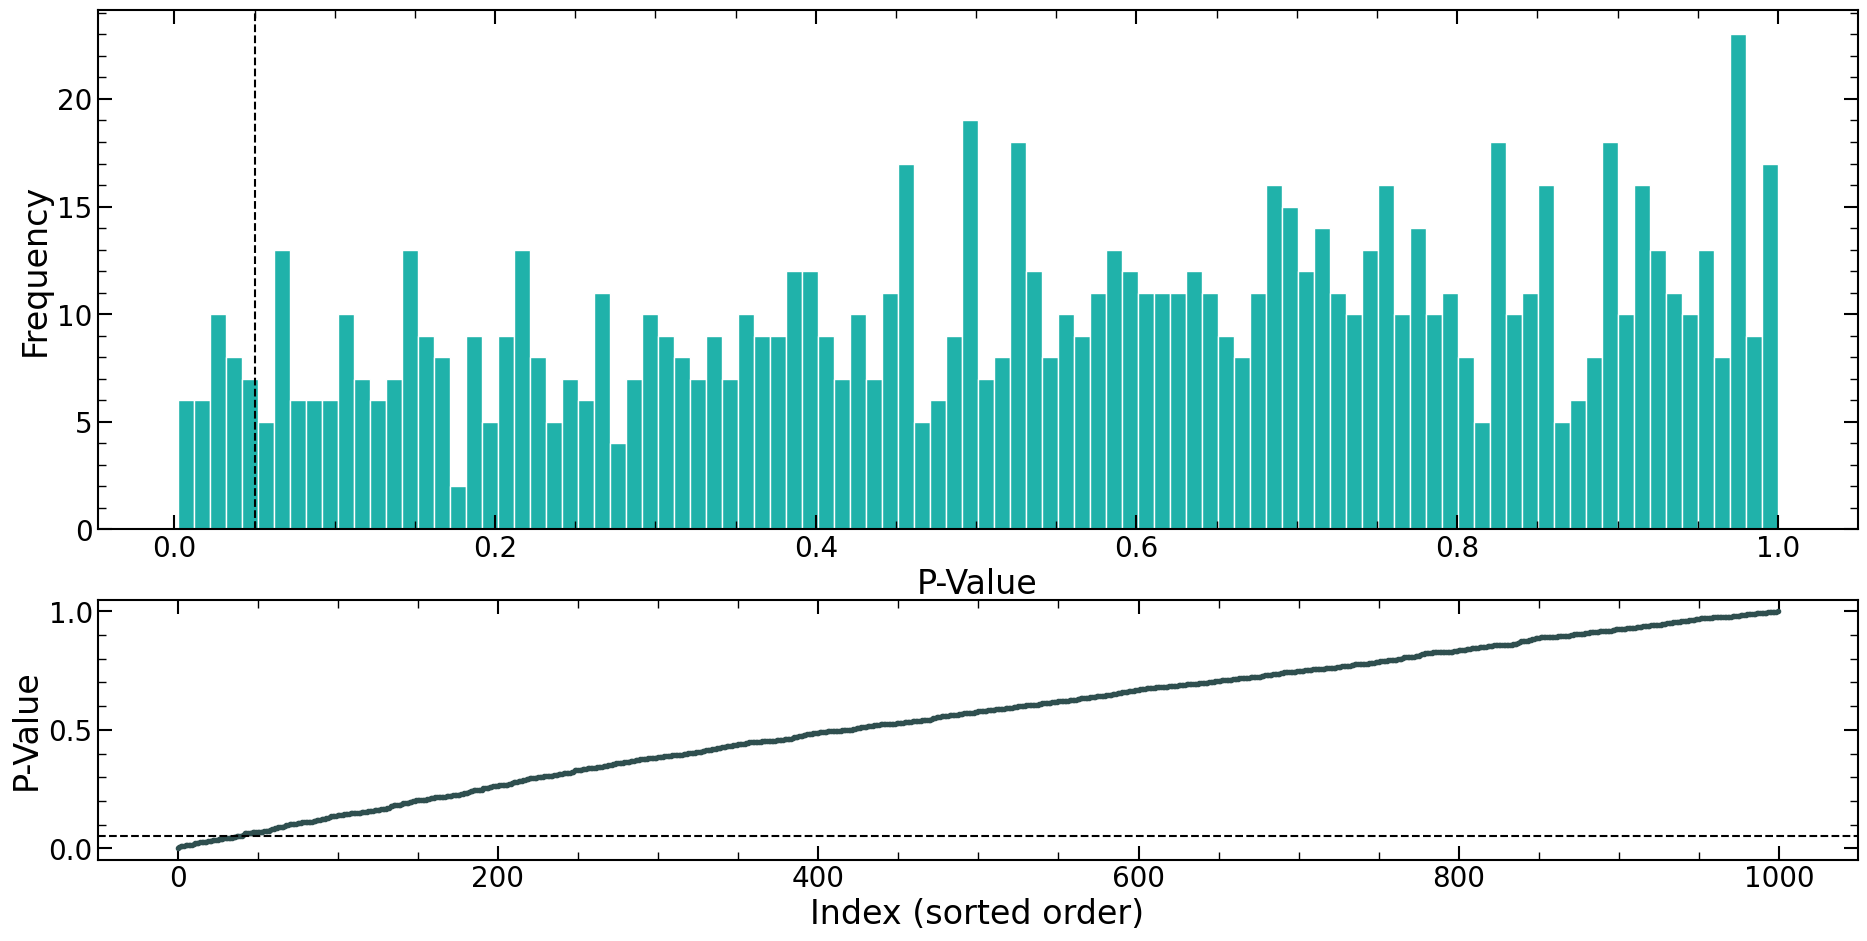

In [28]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Read your data
prices = 'combined_tape.csv'
tape_df = pd.read_csv(prices)

# Assign a group number whenever 'timestamp' resets (goes backward)
tape_df['Group'] = (tape_df['timestamp'] < tape_df['timestamp'].shift()).cumsum()

# Prepare lists to hold LB test statistics and p-values
lb_stats = []
p_vals = []

# Loop over each group
for grp, grp_df in tape_df.groupby('Group'):
    # Calculate interarrival times within the group
    intervals = grp_df['timestamp'].diff().dropna()
    
    # Skip groups that are too small
    if len(intervals) < 2:
        continue
    
    # Perform the Ljung-Box test (using lag=10 or fewer if not enough data)
    lag = 10 if len(intervals) > 10 else len(intervals) - 1
    lb_test = acorr_ljungbox(intervals, lags=[lag], return_df=True)
    
    # Extract test statistic and p-value
    lb_stat = lb_test["lb_stat"].values[0]
    p_value = lb_test["lb_pvalue"].values[0]
    
    lb_stats.append(lb_stat)
    p_vals.append(p_value)

size = 24

# Convert p_vals to a NumPy array
p_vals = np.array(p_vals)

# Create one figure with three subplots
fig, axes = plt.subplots(
    nrows=2, ncols=1, figsize=(20, 10),
    gridspec_kw={'height_ratios': [2, 1]}  # or any other ratio you prefer
)



# 2) Histogram of p-values
axes[0].hist(p_vals, bins=100, edgecolor='white', color='lightseagreen')
axes[0].axvline(0.05, color='black', linestyle='--', label='Significance Threshold')
axes[0].set_xlabel('P-Value', size = size)
axes[0].set_ylabel('Frequency', size = size)
#axes[1].legend(loc = 'upper left')

# 3) Line plot of sorted p-values
sorted_p = np.sort(p_vals)
axes[1].plot(sorted_p, marker='.', linestyle='-', color='darkslategray')
axes[1].axhline(0.05, color='black', linestyle='--', label='Significance Threshold')
axes[1].set_xlabel('Index (sorted order)', size = size)
axes[1].set_ylabel('P-Value', size = size)
#axes[2].legend()

for i in range(0,2):
    axes[i].minorticks_on()
    axes[i].minorticks_on()
    axes[i].tick_params(axis='both', which='major', direction='in', length=10, width=1.5, labelsize=20,
                    top=True, bottom=True, left=True, right=True)
    axes[i].tick_params(axis='both', which='minor', direction='in', length=6, width=1,
                    top=True, bottom=True, left=True, right=True)
    axes[i].tick_params(axis='both', which='major', direction='in', length=10, width=1.5, labelsize=20,
                    top=True, bottom=True, left=True, right=True)
    axes[i].tick_params(axis='both', which='minor', direction='in', length=6, width=1,
                    top=True, bottom=True, left=True, right=True)

# Apply thicker border edges to both subplots
for ax in axes:
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)  # Adjust thickness (2 is thicker, increase if needed)

fig.subplots_adjust(
    wspace=0.05,
    hspace=0.18,
    left=0.07,
    right=0.95,
    top=0.92,
    bottom=0.07
)


plt.show()


-----

KS Test on LOB order arrivals 

In [15]:
# Initialize lists
time_list, bid_total_quantity, bid_prices, bid_quantities = [], [], [], []
ask_total_quantity, ask_prices, ask_quantities = [], [], []

# Read the file and parse the data
with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()
        
        # Split the line using "Bid:" and "Ask:" as delimiters
        parts = re.split(r'(Bid:|Ask:)', line)
        time_stamp = float(parts[0].strip().rstrip(','))
        
        # Parse bid and ask data
        bid_data, ask_data = [], []
        for i in range(1, len(parts) - 1, 2):
            values = [int(val) for val in parts[i + 1].strip().split(',') if val.strip().isdigit()]
            if parts[i] == 'Bid:':
                bid_data = values
            elif parts[i] == 'Ask:':
                ask_data = values
        
        # Extract and assign bid data
        if bid_data:
            bid_total_quantity.append(bid_data[0])
            bid_prices.append(bid_data[1::2])  # Take prices at odd indices
            bid_quantities.append(bid_data[2::2])  # Take quantities at even indices
        else:
            bid_total_quantity.append(None)
            bid_prices.append([])
            bid_quantities.append([])
        
        # Extract and assign ask data
        if ask_data:
            ask_total_quantity.append(ask_data[0])
            ask_prices.append(ask_data[1::2])  # Take prices at odd indices
            ask_quantities.append(ask_data[2::2])  # Take quantities at even indices
        else:
            ask_total_quantity.append(None)
            ask_prices.append([])
            ask_quantities.append([])

        # Store the timestamp
        time_list.append(time_stamp)

# Create the expanded DataFrame
expanded_df = pd.DataFrame({
    'Time': time_list,
    'Bid Total Quantity': bid_total_quantity,
    'Bid Prices': [', '.join(map(str, prices)) for prices in bid_prices],
    'Bid Quantities': [', '.join(map(str, quantities)) for quantities in bid_quantities],
    'Ask Total Quantity': ask_total_quantity,
    'Ask Prices': [', '.join(map(str, prices)) for prices in ask_prices],
    'Ask Quantities': [', '.join(map(str, quantities)) for quantities in ask_quantities]
})

# Display the expanded DataFrame
expanded_df.head(5)


,Time,Bid Total Quantity,Bid Prices,Bid Quantities,Ask Total Quantity,Ask Prices,Ask Quantities
0,0.000,0,,,0,,
1,0.067,0,,,1,260,1
2,0.133,0,,,2,"260, 447","1, 1"
3,0.142,1,139,1,2,"260, 447","1, 1"
4,0.167,1,139,1,3,"260, 291, 447","1, 1, 1"


In [16]:
# Suppose your snapshot-based DataFrame is `df` with columns like:
# ["Time", "Bid Total Quantity", "Bid Prices", "Bid Quantities", "Ask Total Quantity", "Ask Prices", "Ask Quantities"]
df = expanded_df
# 1) Sort by time if not already sorted
df = df.sort_values("Time")

# 2) Create columns for the change in total quantity from one snapshot to the next
df["Delta_BidQty"] = df["Bid Total Quantity"].diff()
df["Delta_AskQty"] = df["Ask Total Quantity"].diff()

# 3) Filter the rows where there's a positive change in bid quantity
df_bids = df[df["Delta_BidQty"] > 0].copy()
# 4) Filter the rows where there's a positive change in ask quantity
df_asks = df[df["Delta_AskQty"] > 0].copy()

# Now we can get the times for those arrivals
bid_arrival_times = df_bids["Time"].values
ask_arrival_times = df_asks["Time"].values

# 5) Compute inter-arrival times
bid_inter_arrival_times = np.diff(bid_arrival_times)
ask_inter_arrival_times = np.diff(ask_arrival_times)


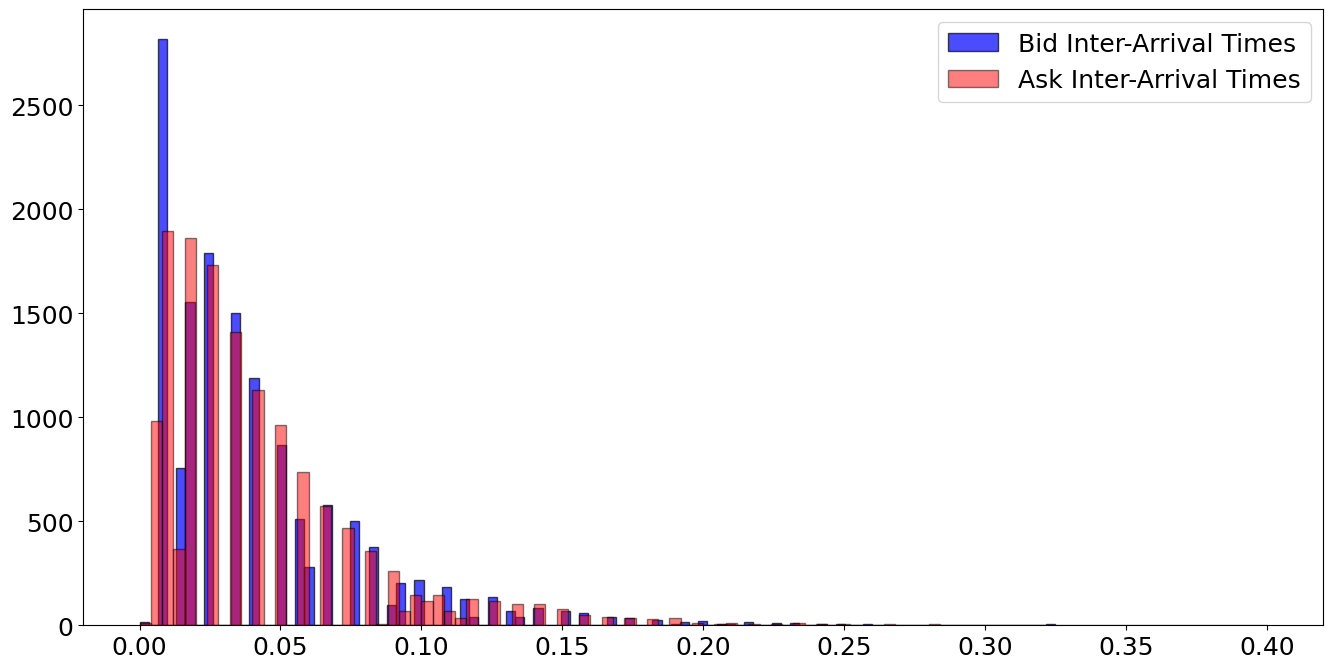

In [17]:
fig = plt.figure(figsize=(16, 8))
plt.hist(bid_inter_arrival_times, bins=100, color='blue', alpha=0.7, edgecolor='black', density=False, label='Bid Inter-Arrival Times')
plt.hist(ask_inter_arrival_times, bins=100, color='red', alpha=0.5, edgecolor='black', density=False, label='Ask Inter-Arrival Times')
plt.legend()
plt.show()

In [18]:
import scipy.stats as stats

def run_ks_test(inter_arrival_times, side_name="Bid"):
    # Filter out non-positive intervals if they exist
    data = inter_arrival_times[inter_arrival_times > 0]
    if len(data) < 2:
        print(f"[{side_name}] Not enough data points.")
        return

    # Fit exponential (Poisson arrivals => exponential inter-arrivals)
    lambda_hat = 1 / np.mean(data)
    exp_dist = stats.expon(scale=1/lambda_hat)

    # Run KS test
    D_stat, p_value = stats.kstest(data, exp_dist.cdf)
    print(f"[{side_name}] KS Statistic: {D_stat:.4f}")
    print(f"[{side_name}] p-value: {p_value:.4g}")
    if p_value < 0.05:
        print(f"[{side_name}] Reject the null (not Poisson).")
    else:
        print(f"[{side_name}] Fail to reject (consistent w/ Poisson).")

# Example usage
run_ks_test(bid_inter_arrival_times, side_name="Bid")
run_ks_test(ask_inter_arrival_times, side_name="Ask")


[Bid] KS Statistic: 0.1733
[Bid] p-value: 0
[Bid] Reject the null (not Poisson).
[Ask] KS Statistic: 0.1717
[Ask] p-value: 0
[Ask] Reject the null (not Poisson).


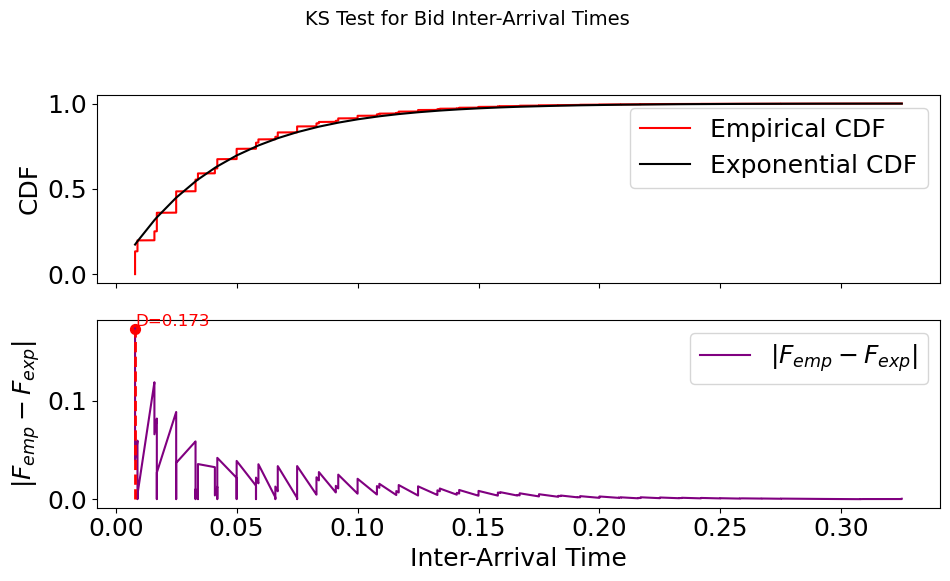

[Bid] KS Statistic: 0.1733
[Bid] p-value: 0
[Bid] Reject null hypothesis (not Poisson).


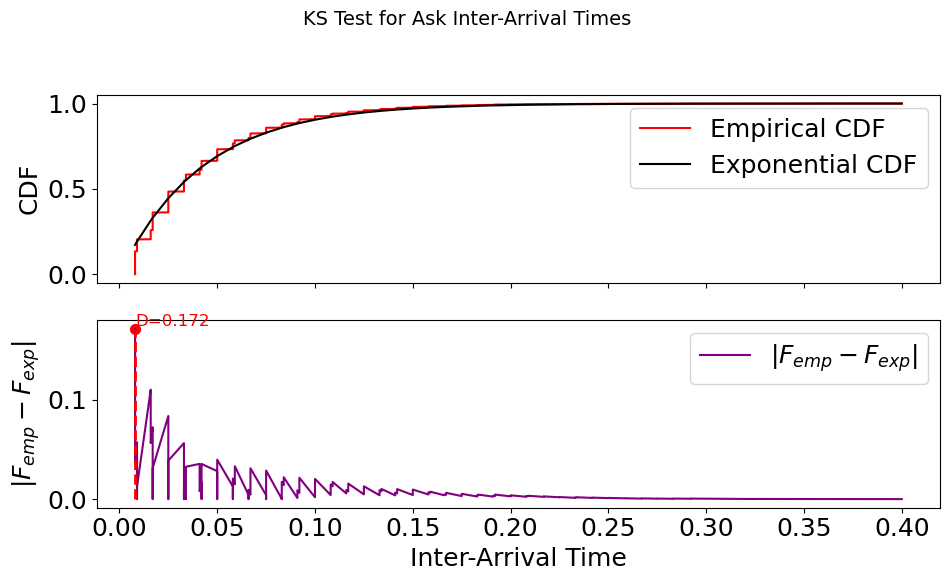

[Ask] KS Statistic: 0.1717
[Ask] p-value: 0
[Ask] Reject null hypothesis (not Poisson).


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def plot_ks_results(inter_arrival_times, side_name="Bid"):
    """
    Plots empirical CDF vs. exponential CDF (fitted from data)
    and shows the Kolmogorov-Smirnov (KS) difference.
    """
    # Filter out any zero or negative intervals (if any exist)
    data = inter_arrival_times[inter_arrival_times > 0]
    data = np.sort(data)
    N = len(data)
    
    if N < 2:
        print(f"[{side_name}] Not enough data points to plot or run KS.")
        return

    # === Fit Exponential Distribution ===
    lambda_hat = 1 / np.mean(data)  # 1 / mean inter-arrival time
    exp_dist = stats.expon(scale=1 / lambda_hat)
    
    # === Compute Empirical CDF ===
    empirical_cdf = np.arange(1, N+1) / N
    
    # === Theoretical CDF (Exponential) ===
    theoretical_cdf = exp_dist.cdf(data)
    
    # === KS Test ===
    D_statistic, p_value = stats.kstest(data, exp_dist.cdf)
    
    # === Prepare Subplots ===
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True,
                             gridspec_kw={'height_ratios': [1, 1]})
    fig.suptitle(f"KS Test for {side_name} Inter-Arrival Times", fontsize=14)
    
    # === (1) Upper Plot: Empirical vs Theoretical CDF ===
    axes[0].plot(data, empirical_cdf, label="Empirical CDF", color="red")
    axes[0].plot(data, theoretical_cdf, label="Exponential CDF", color="black")
    axes[0].set_ylabel("CDF")
    axes[0].legend(loc="best")
    
    # === (2) Lower Plot: |F_emp - F_theory| ===
    ks_diff = np.abs(empirical_cdf - theoretical_cdf)
    axes[1].plot(data, ks_diff, label=r"$|F_{emp} - F_{exp}|$", color="purple")
    
    # Highlight the max difference
    max_diff_idx = np.argmax(ks_diff)
    max_x = data[max_diff_idx]
    max_y = ks_diff[max_diff_idx]
    axes[1].vlines(max_x, 0, max_y, color="red", linestyle="dashed", linewidth=2)
    axes[1].scatter([max_x], [max_y], color="red", s=50, marker="o")
    axes[1].text(max_x, max_y, f"D={D_statistic:.3f}", color="red", fontsize=12,
                 ha="left", va="bottom")
    
    axes[1].set_ylabel(r"$|F_{emp} - F_{exp}|$")
    axes[1].set_xlabel("Inter-Arrival Time")
    axes[1].legend(loc="best")
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
    plt.show()
    
    # === Print KS Results ===
    print(f"[{side_name}] KS Statistic: {D_statistic:.4f}")
    print(f"[{side_name}] p-value: {p_value:.4g}")
    if p_value < 0.05:
        print(f"[{side_name}] Reject null hypothesis (not Poisson).")
    else:
        print(f"[{side_name}] Fail to reject (consistent w/ Poisson).")

plot_ks_results(bid_inter_arrival_times, side_name="Bid")
plot_ks_results(ask_inter_arrival_times, side_name="Ask")
